# What is driving customer churn at Telco?

### 4 Questions


1. Do customers with higher monthly_charges churn at a different rate?    
2. Do customers with a partner or dependents churn at a different rate?  
3. What month are customers most likely to churn?  
4. Do customers with more addons churn at a different rate?  

### All relationships were statistically significant which is odd
### All customers churned in the same month which is very odd

## Imports

In [1]:
# import libraries and modules
import acquire
import prepare
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier



## Acquire


Import data from the telco_churn Database on the Codeup DB Server using a SQL query on 1/2/23

In [2]:
# Acquire data 
df = acquire.get_telco_data()  # Import data using acquire file
print('Rows, Columns ',df.shape,'\n') #View shape of df
print(df.columns) #View column names

Rows, Columns  (7043, 25) 

Index(['customer_id', 'payment_type_id', 'internet_service_type_id',
       'contract_type_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'internet_service_type',
       'payment_type', 'churn_month'],
      dtype='object')


Our df has 7043 rows which each represent a customer. Our columns give us more information on each customer such as how much they pay each month, how much they've paid total, and how many addons they subscribe to above the basic internet subscription.

## Prepare

* List steps taken to clean your data here
* In particular call out how you handle null values and outliers in detail
* You must do this even if you do not do anything or do not encounter any
* Any time there is potential to make changes to the data you must be upfront about the changes you make or do not make

1. Drop following columns: 'Unnamed: 0','payment_type_id', 'internet_service_type_id', 'contract_type_id','customer_id'  
2. Turn 'total_charges' into a float. 
3. Create 'addons' column which sums the values from 'phone_service', 'multiple_lines', 'online_security','online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies'  
4. Create dummy values to use for Machine Learning

There are no null values to deal with

In [3]:
df, customer_id = prepare.prep_telco(df) # Clean df


Split data into train, validate, and test in order to start exploring the questions

In [4]:
#split data into full, train, validate, test
full, train, X_train, y_train, X_val, y_val, X_test, y_test = prepare.split_data(df,'churn') 

## Explore


### Do customers with higher monthly_charges churn at a different rate?

In [5]:
# Print out monthly_avg mean and churn rates of customers who pay above and below average per month
monthly_avg = train.monthly_charges.mean()
above_avg = train[train['monthly_charges']>monthly_avg].churn.mean()
below_avg = train[train['monthly_charges']<monthly_avg].churn.mean()
monthly_avg, above_avg, below_avg

(64.91416434187154, 0.34814143245693563, 0.1600460564191134)

The average monthly charges for all customers is $64.81. Customers who pay more than that churn at a rate of 34%. Customers who pay less churn at a rate of 16%

<AxesSubplot:title={'center':'Pay Less'}>

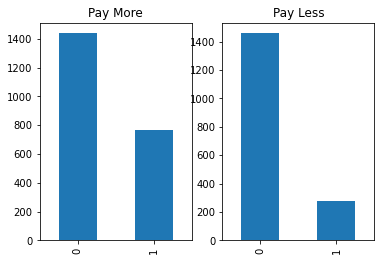

In [6]:
# Create two bar charts
fig, axes = plt.subplots(nrows=1, ncols=2)
train[train['monthly_charges']>monthly_avg].churn.value_counts().plot(ax=axes[0], kind='bar',title='Pay More')
train[train['monthly_charges']<monthly_avg].churn.value_counts().plot(ax=axes[1], kind='bar',title='Pay Less')

There are more than double the amount of people who churn who pay more than average compared to paying less than average

We will run a one-sample T-test to determine whether there is a stastically significant difference between the monthly charges of customers who churn compared to those who don't

Hypothesis:  
H0: Churn is independent of monthly_charges  
Ha: Churn is dependent on monthly_charges

In [7]:
# Run T-Test
alpha = .05  #set alpha level
churn_sample = train[train.churn == 1].monthly_charges  #setup monthly_charges for people who have churned
overall_mean = train.monthly_charges.mean() #overall mean

t, p = stats.ttest_1samp(churn_sample, overall_mean) #one-sample T-test

if p < alpha:
    print(f'There is a statistically significant difference: alpha = .05, p = {round(p,2)}')

There is a statistically significant difference: alpha = .05, p = 0.0


There is indeed a difference in monthly charges between customers who churn and those who don't

### Do customers with a partner or dependents churn at a different rate?

<AxesSubplot:title={'center':'No Dependent or Partner'}>

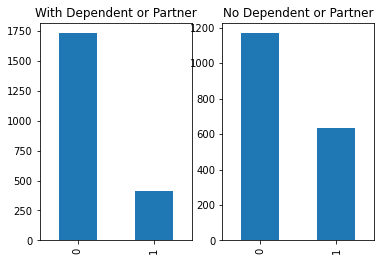

In [8]:
# Create two bar plots
fig, axes = plt.subplots(nrows=1, ncols=2)
train[(train.partner==1) | (train.dependents==1)].churn.value_counts().plot(ax=axes[0], kind='bar',title='With Dependent or Partner')

train[(train.partner==0) & (train.dependents==0)].churn.value_counts().plot(ax=axes[1], kind='bar',title='No Dependent or Partner')

We will run a chi^2 test to see if there is a statistically significant relationship between churn and whether a customer has a dependent or partner

Hypothesis:  
H0: Churn is independent of parner_dep  
Ha: Churn is dependent on parner_dep

In [9]:
# Run chi2 test
alpha = .05
observed = pd.crosstab(train.churn, train.partner_dep)
chi2, p, degf, expected = stats.chi2_contingency(observed)
if p<alpha:
    print('There is a statistically significant relationship')

There is a statistically significant relationship


Customers with no dependent or partner are churning at a higher rate than those without

## What month are customers most likely to churn?

In [10]:
# Value counts of churn
train[train['churn']==1][['churn_month']].value_counts()

churn_month
2022-01-31     1046
dtype: int64

Every customer churned on the exact same date - Jan 31, 2022!

## Do customers with more addons churn at a different rate?

Run a chi square test to check for statistically significant relationship

<AxesSubplot:xlabel='churn', ylabel='count'>

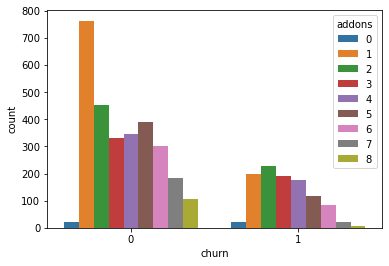

In [11]:
# Create countplot between churn and addons
sns.countplot(data=train,x='churn',hue='addons')

It looks like customers with only 1 addon churn at a different rate.

Hypothesis:  
H0: Churn is independent of addons   
Ha: Churn is dependent on addons

In [12]:
# Set alpha level and run chi2 test
alpha = .05
observed = pd.crosstab(train.churn,train.addons)
chi2, p, degf, expected = stats.chi2_contingency(observed)
if p<alpha:
    print('There is a statistically significant relationship')

There is a statistically significant relationship


Some relationship exists between the number of addons and churn rate.

## Exploration Summary

- Every feature I explored was statistically significant which is odd
- Every customer churned in the same month which is odd

## Modeling

### Introduction


Create a baseline model which predicts that the customer will not churn

In [13]:
# Find the percent of customers who have churned - our baseline
print(f'Baseline: {1-round(df.churn.sum()/df.shape[0],2)} evaluation metric')

Baseline: 0.73 evaluation metric


In [14]:
# Remove object dtypes from my dfs
X_train = X_train.select_dtypes(exclude ='object')
X_val = X_val.select_dtypes(exclude ='object')
X_test = X_test.select_dtypes(exclude ='object')
full = full.select_dtypes(exclude ='object').drop(columns='churn')

### Random Forest

Use RandomizedSearchCV to fine tune hyperparameters and compare to non-optimized hyperparameters

In [15]:
# Create range for each hyperparameter
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [16]:
# RandomForest - sub-optimal parameters
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=21)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_train)
y_pred_proba = rf.predict_proba(X_train)
print('Accuracy of Random Forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))
print('Accuracy of Random Forest classifier on validate set: {:.2f}'
     .format(rf.score(X_val, y_val)))



Accuracy of Random Forest classifier on training set: 0.77
Accuracy of Random Forest classifier on validate set: 0.77


In [17]:
# RandomForest - optimal parameters
rf = RandomForestClassifier(n_estimators= 200,
                             min_samples_split= 5,
                             min_samples_leaf= 4,
                             max_features= 'auto',
                             max_depth= 10,
                             bootstrap= True, 
                            random_state=21)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_train)
y_pred_proba = rf.predict_proba(X_train)
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))
print('Accuracy of random forest classifier on validation set: {:.2f}'
     .format(rf.score(X_val, y_val)))

Accuracy of random forest classifier on training set: 0.85
Accuracy of random forest classifier on validation set: 0.82


### Logistic Regression

In [18]:
# LogisticRegression
lr = LogisticRegression(C=1, random_state=21, intercept_scaling=1, solver='lbfgs',max_iter=500)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)
y_pred_proba = lr.predict_proba(X_train)
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(lr.score(X_train, y_train)))
print('Accuracy of Logistic Regression classifier on validation set: {:.2f}'
     .format(lr.score(X_val, y_val)))



Accuracy of Logistic Regression classifier on training set: 0.78
Accuracy of Logistic Regression classifier on validation set: 0.81


### K-Nearest Neighbor

In [19]:
# K-Nearest Neighbor
knn = KNeighborsClassifier(n_neighbors=15, weights='uniform')
knn.fit(X_train, y_train)

print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of KNN classifier on validate set: {:.2f}'
     .format(knn.score(X_val, y_val)))


Accuracy of KNN classifier on training set: 0.80
Accuracy of KNN classifier on validate set: 0.79


How accurate is KNN using different n_neighbors?

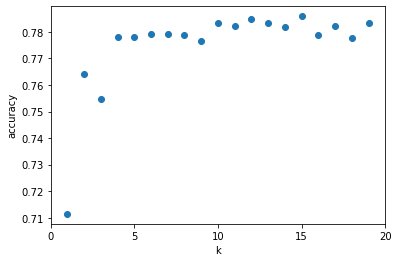

In [20]:
# Plot accuracy levels for different n_neighbors levels on validate set
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_val, y_val))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])
plt.show()

### KNN has the highest non-optimized hyperparameters accuracy score on our validate set with a rate of .79 . We will use this model on our test set

### Test Model
* We will use our KNN model on our Test set as it performed best on our Validate set


In [21]:
# Code that runs the best overall model on test data (this may be imported from a module)
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))
print('Compared to accuracy of KNN classifier on validate set: {:.2f}'
     .format(knn.score(X_val, y_val)))

Accuracy of KNN classifier on test set: 0.77
Compared to accuracy of KNN classifier on validate set: 0.78


### Modeling Wrap 
Using a KNN model we were able to improve the accuracy of our baseline of 73% accuracy to expected 77% accuracy.

Now we will create a csv of each customer and our prediction and probability that they will churn

In [22]:
# Predict full data and concatenate customer_id with prediction and probability
y_pred = knn.predict(full)
y_pred_proba = knn.predict_proba(full)
y_pred = pd.Series(y_pred)
y_pred_proba = pd.DataFrame(y_pred_proba)
y_pred_proba = y_pred_proba.iloc[:,1]
pred = pd.concat([customer_id,y_pred,y_pred_proba],axis=1)
pred.columns = ['customer_id','prediction','probability']

In [ ]:
# Save predictions to csv
pred.to_csv('predictions.csv')

## Conclusion

### Key Findings
Every churned customer churned on the exact same date. Unless there was some apocopyptic business event, this makes me question the validity of the whole data. Every feature I investigated had a statistically significant relationship to churn. Again, this makes me question the validity of the data. If everything is a driver, then nothing is a driver.

### Recommendations
I suggest that this data's validity need to be investigated. Business decisions should not be made from bad data.

### Next Steps
I would investigate the data source and attempt to obtain better data.